<a href="https://colab.research.google.com/github/OSGeoLabBp/tutorials/blob/master/english/data_processing/lessons/circle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Regression circle

How can we fit a circle on three or more points?

First let's try the least squares method (LSM) to find a solution.

Unfortunately the equation of the circle is not linear:

${(x - x_0)}^{2} + {(y - y_0)}^{2} = r^2$

We have x and y positions of points on the circle, and we would like to find $x_0, y_0, r$.
Removing the bracket we get:

$x^2 - 2 x x_0 + {x_0}^2 + y^2 -2 y y_0 + {y_0}^2 = r^2$

Let's reorder the tags:

$y^2 + x^2  -2 x_0 x -2 y_0 y + x_0^2 + y_0^2 -r^2 = 0$

Lest substitute the unknowns:

$a_1 = -2 x_0$

$a_2 = -2 y_0$

$a_3 = x_0^2 + y_0^2 - r^2$

$x a_1 + y a_2 + a_3 =  -(x^2 + y^2)$

So we get a linear equation of three unknowns $a_1, a_2, a_3$ for each measured point,
which is solved applying LSM using numpy.

Finally we can calculate the original unknowns:

$x_0 = -0.5 a_1$

$y_0 = -0.5 a_2$

$r = \sqrt {x_0^2 + y_0^2 - a_3}$

In [ ]:
from math import sqrt, pi, sin, cos, sqrt, log   # used mathematical and trigonometrical functions
import numpy as np                          # matrix operations
import matplotlib.pyplot as plt             # chart plotting
from random import shuffle

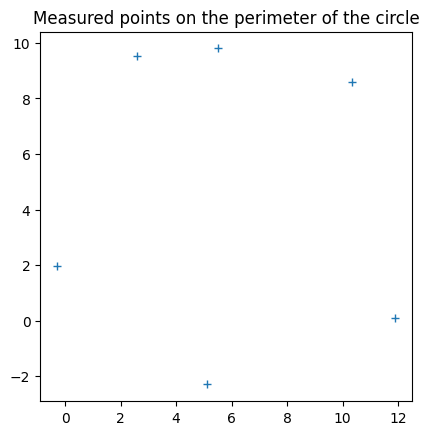

In [ ]:
# sample data
x = np.array([ 11.88, 10.34, 2.58, -0.29, 5.1, 5.5])
y = np.array([  0.08,  8.59, 9.54,  1.95, -2.3, 9.8 ])
plt.plot(x, y, '+')
plt.axis('scaled')
_ = plt.title('Measured points on the perimeter of the circle')

Setting up and solving the equation system

$A x = b$

\begin{align}
        x = \begin{pmatrix}
            a_1 \\
            a_2 \\
            a_3
            \end{pmatrix}.
\end{align}

\begin{align}
        A = \begin{pmatrix}
            x_1 & y_1 & 1 \\
            x_2 & y_2 & 1 \\
            x_3 & y_3 & 1 \\
            x_4 & y_4 & 1 \\
            x_5 & y_5 & 1 \\
            x_6 & y_6 & 1
        \end{pmatrix}.
\end{align}

\begin{align}
    b = - \begin{pmatrix}
        x_1^2 + y_1^2 \\
        x_1^2 + y_1^2 \\
        x_1^2 + y_1^2 \\
        x_1^2 + y_1^2 \\
        x_1^2 + y_1^2 \\
        x_1^2 + y_1^2
    \end{pmatrix}.
\end{align}

Note in the formula above the matrix indices start from 1 while in Python they start from 0.

In [ ]:
# coefficients of unknowns
A = np.stack((x, y, np.full(x.size, 1.0)), axis=1)
# pure terms
b = -(x * x + y * y)
# solution for a1, a2, a3
Q = np.linalg.inv(np.matmul(A.T, A))
par = np.matmul(Q, np.matmul(A.T, b))
# calculating the original unknowns
x0 = -0.5 * par[0]
y0 = -0.5 * par[1]
r = sqrt(x0**2 + y0**2 - par[2])
print("The equation of the circle")
print(f"(x - {x0:.3f})^2 + (y - {y0:.3f})^2 = {r:.3f}")

The equation of the circle
(x - 6.128)^2 + (y - 3.729)^2 = 6.495


Accuracy can be described by the residuals from the original equations:

$res = \sqrt{{(x - x_0)}^{2} + {(y - y_0)}^{2}} - r$

In [ ]:
# residuals
res = np.sqrt((x - x0)**2 + (y - y0)**2) -r
print("residuals:")
print([f"{v:.3f} " for v in res])

residuals:
['0.316 ', '-0.063 ', '0.314 ', '0.165 ', '-0.380 ', '-0.392 ']


and by the root mean square error:

$rms = \sqrt {\frac {\sum{res^2}} {n}}$

In [ ]:
#root mean square error
rms = sqrt(np.mean(res**2))
print(f"rms: {rms:.3f} m")

rms: 0.296 m


Let's display points and circle

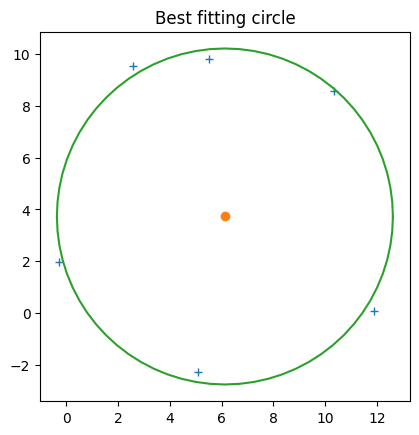

In [ ]:
plt.plot(x, y, '+')
plt.plot(x0, y0, 'o')
plt.plot([x0 + r * cos(alfa / 180 * pi) for alfa in range(0, 361, 5)],
         [y0 + r * sin(alfa / 180 * pi) for alfa in range(0, 361, 5)])
plt.axis('scaled')
_ = plt.title("Best fitting circle")

Let's calculate the estimated accuracy of the unknowns $a_1, a_2, a_3$. The weight coefficient matrix of unknowns  is the inverse of normal matrix:
$Q = {N}^{-1}=(A^TA)^{-1}$

The mean error of unit weight (called as proportionality factor, too):

$c^2 = \frac {\sum{v^2}} {(n-3)}$ where $v = Ax -l$

The variance and covariance matrix:

$C=c^2Q$

The square of the standard deviation of unkowns ${a_1, a_2, a_3}$ are in the diagonal of the variance and covariance matrix.

Applying the error propagation law, we can get the standard deviation of ${x_0}$, ${y_0}$ and ${r}$. The matrix containg the partial derivatives of the functions to compute ${x_0}$, ${y_0}$ and ${r}$ from ${a_1}$, ${a_2}$ and ${a_3}$:

$F^T=\begin{bmatrix} -0.5 & 0 & 0 \\ 0 & -0.5 & 0 \\ \frac {1} {4r}a_1 & \frac {1} {4r}a_2 & -\frac {1} {r} \end{bmatrix}=\begin{bmatrix} -0.5 & 0 & 0 \\ 0 & -0.5 & 0 \\ -\frac {x_0} {2r} & -\frac {y_0} {2r} & -\frac {1} {2r} \end{bmatrix}$

The variance and covariance matrix of ${x_0}$, ${y_0}$ and ${r}$:

$C_Y=F^TCF$

The variances of ${x_0}$, ${y_0}$ and ${r}$ are in the diagonal of $C_Y$.

In [ ]:
# residuals computed from a1, a2, a3
resa = np.dot(A, par) - b
print("residuals:")
print([f"{v:.3f} " for v in resa])
c2 = np.sum(resa**2) / (np.size(x)-3)
C = c2 * Q
F = np.array([ [-0.5, 0, 0], [0, -0.5, 0], [1/4/r*par[0], 1/4/r*par[1], -1/2/r] ]).T
C_Y = np.matmul(np.matmul(F.T, C), F)
print(f"stdev_x0: {sqrt(C_Y[0][0]):.3f} m  stdev_y0: {sqrt(C_Y[1][1]):.3f} m  stdev_r: {sqrt(C_Y[2][2]):.3f} m")

residuals:
['4.201 ', '-0.821 ', '4.174 ', '2.169 ', '-4.790 ', '-4.934 ']
stdev_x0: 0.263 m  stdev_y0: 0.227 m  stdev_r: 0.173 m


# Robust estimation of circle parameters using RANSAC

What happens if we have one or more outliers among the points? If we have few points we can find outlier from a figure or we can use data snooping. Using laser scanners or photogrammetry we get point clouds where there are huge number of points and usually many outliers/noise.

This case Random Sample Consensus (RANSAC) comes into consideration.

Let's create first a function to get the best fitting (LSM) circle through 3 or more points.

In [ ]:
def circle(x, y):
    """ circle through points
        returns tuple of x0, y0, r
    """
    # coefficients of unknowns
    A = np.stack((x, y, np.full(x.size, 1.0)), axis=1)
    # pure term
    b = -(x * x + y * y)
    # solution for a1, a2, a3
    Q = np.linalg.inv(np.matmul(A.T, A))
    par = np.matmul(Q, np.matmul(A.T, b))
    # calculating the original unknowns
    x0 = -0.5 * par[0]
    y0 = -0.5 * par[1]
    r = sqrt(x0**2 + y0**2 - par[2])
    #residuals
    res = np.sqrt((x - x0)**2 + (y - y0)**2) -r
    #root mean square error
    rms = sqrt(np.mean(res**2))
    return x0, y0, r, rms

Test the function using point from the first section.

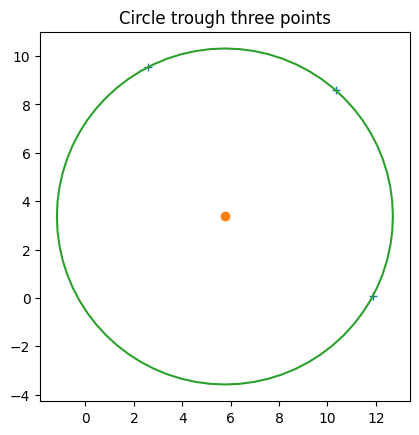

In [ ]:
# circle through three points
x0, y0, r, rms = circle(x[0:3], y[0:3])
plt.plot(x[:3], y[:3], '+')
plt.plot(x0, y0, 'o')
plt.plot([x0 + r * cos(alfa / 180 * pi) for alfa in range(0, 361, 5)],
         [y0 + r * sin(alfa / 180 * pi) for alfa in range(0, 361, 5)])
plt.axis('scaled')
_ = plt.title("Circle trough three points")

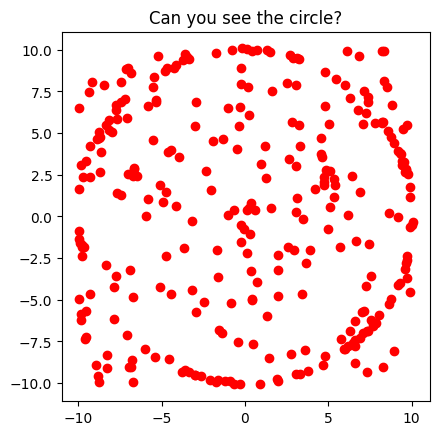

In [ ]:
# generating test data
from random import random, seed, randint
seed()
# random points on circle
n = 100    # number of points on the circle
m = 200    # number of outlier points
r_range = 0.2
r_base = 10.0
x = np.zeros(n+m)
y = np.zeros(n+m)
# points close to circle
for i in range(n):
    alpha = random() * pi * 2   # angle between 0-360 degree in radians
    r = r_base + (random() - 0.5) * r_range   # random radius
    x[i] = r * sin(alpha)
    y[i] = r * cos(alpha)
# outlier (random) points
for i in range(n, n+m):
    x[i] = random() * 2 * r_base -r_base
    y[i] = random() * 2 * r_base -r_base
plt.plot(x, y, 'ro')
plt.title("Can you see the circle?")
_ = plt.axis('scaled')

Fit circle to randomly selected three points several times and choose the one which is close to the most points. Try to run the code several times and evaluate the results.

In [ ]:
# RANSAC run this block several times and exemine the results
p = 0.99 # needed probability for RANSAC result
n_try = int(log(1 - p) / log(1 - (n / (n + m))**3))
print(f"Estimated number of neccesary iterations: {n_try}")
best = 0
print("centerx  centery   radius    fit   iter")
for i in range(n_try):
    index = [randint(0, n+m-1) for i in range(3)]    # three random index
    x3 = x[index]   # three random points
    y3 = y[index]
    xc, yc, r3, rms = circle(x3, y3)
    # distance from the circle
    dist = np.absolute(np.sqrt((x - xc)**2 + (y - yc)**2) - r3)
    n_fit = dist[dist < r_range/2].size
    #print(index, i, n_fit)
    if n_fit > best:
        best = n_fit
        best_xc = xc
        best_yc = yc
        best_r = r3
        print(f"{best_xc:7.3f}  {best_yc:7.3f}  {best_r:7.3f}  {best:5d}  {i:5d}")

Estimated number of neccesary iterations: 122
centerx  centery   radius    fit   iter
-18.087    7.636   22.187      5      0
 -1.181   -0.496   10.728     14      1
 -1.549   -4.317    8.877     18      2
 -0.887   -0.326   10.524     22     10
  1.398   -0.579    8.679     25     33
  0.078    0.087    9.940     62     35
 -0.042    0.008    9.982     83     37


# of inliers: 83
# of outliers: 217


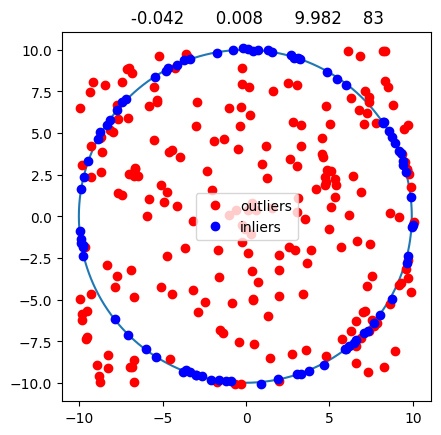

In [ ]:
# plot result
plt.title(f"{best_xc:10.3f} {best_yc:10.3f} {best_r:10.3f} {best:5d}")
plt.plot([best_xc + best_r * sin(alfa / 180 * pi) for alfa in range(0, 361)],
         [best_yc + best_r * cos(alfa / 180 * pi) for alfa in range(0, 361)])
dist = np.absolute(np.sqrt((x - best_xc)**2 + (y - best_yc)**2) - best_r)
nin = x[dist < r_range/2].size
print(f"# of inliers: {nin:d}")
print(f"# of outliers: {n+m-nin:d}")
plt.plot(x[dist > r_range/2], y[dist > r_range/2], "ro", label='outliers')
plt.plot(x[dist < r_range/2], y[dist < r_range/2], "bo", label="inliers")
plt.axis('scaled')
_ = plt.legend()

Finaly, let's fit LSM circle to the inliers.

In [ ]:
xc_final, yc_final, r_final, rms_final = circle(x[dist < r_range/2], y[dist < r_range/2])
print(f"x0: {xc_final:6.3f}, y0: {yc_final:6.3f}, r: {r_final:6.3f}, rms: {rms_final:6.3f}")

x0: -0.024, y0:  0.014, r:  9.991, rms:  0.050


Let's compute the standard deviations of ${x_0}$, ${y_0}$ and ${r}$!

In [ ]:
def circle_quality(n, A, b, par, r, Q):
  # residuals computed from a1, a2, a3
  resa = np.dot(A, par) - b
  c2 = np.sum(resa**2) / (n - 3)
  C = c2 * Q
  F = np.array([ [-0.5, 0, 0], [0, -0.5, 0], [1/4/r*par[0], 1/4/r*par[1], -1/2/r] ]).T
  C_Y = np.matmul(np.matmul(F.T, C), F)
  return C_Y

def circle_with_quality(x, y):
    """ circle through points
        returns tuple of x0, y0, r
    """
    # coefficients of unknowns
    A = np.stack((x, y, np.full(x.size, 1.0)), axis=1)
    # pure term
    b = -(x * x + y * y)
    # solution for a1, a2, a3
    Q = np.linalg.inv(np.matmul(A.T, A))
    par = np.matmul(Q, np.matmul(A.T, b))
    # calculating the original unknowns
    x0 = -0.5 * par[0]
    y0 = -0.5 * par[1]
    r = sqrt(x0**2 + y0**2 - par[2])
    #residuals
    res = np.sqrt((x - x0)**2 + (y - y0)**2) -r
    #root mean square error
    rms = sqrt(np.mean(res**2))
    C_Y = circle_quality(x.size, A, b, par, r, Q)
    return x0, y0, r, rms, sqrt(C_Y[0][0]), sqrt(C_Y[1][1]), sqrt(C_Y[2][2]), x.size


xc_final, yc_final, r_final, rms_final, xc_st, yc_st, r_st, nin = circle_with_quality(x[dist < r_range/2], y[dist < r_range/2])
print(f"x0: {xc_final:6.3f} +/- {xc_st:.3f} m, y0: {yc_final:6.3f} +/- {yc_st:.3f} m, r: {r_final:6.3f} +/- {r_st:.3f} m")
print(f"rms: {rms_final:6.3f} m, # of inliers: {nin:d}")

x0: -0.024 +/- 0.008 m, y0:  0.014 +/- 0.008 m, r:  9.991 +/- 0.006 m
rms:  0.050 m, # of inliers: 83


# Regression ellipse

How can we fit en ellipse on five or more points? First let's try the least squares method (LSM) to find a solution.

The general equation of an ellipse:

$A x^2 + B xy + C y^2 + D x + E y + F = 0$

If the coordinates $x, y$ are given of points on the ellipse, then the equation above is linear considering $A, B, C, D, E, F$ as unknowns. Substituting several $x, y$ koordinates into the equation, we get a homogen linear equation system. We can use the eigen vectors to find the solution.

$D=\begin{bmatrix} x_1^2 & x_1 y_1 & y_1^2 & x_1 & y_1 & 1 \\ x_2^2 & x_2 y_2 & y_2^2 & x_2 & y_2 & 1 \\ ... \\ x_n^2 & x_n y_n & y_n^2 & x_n & y_n & 1 \end{bmatrix} = \begin{bmatrix} 0 \\ 0 \\ ... \\ 0 \end{bmatrix}$

$S = D^T D$

The least squares solution for the $A, B, C, D, E, F$ unknonws are in the eigen vector of the smallest eigen value of $F$ matrix.

In [ ]:
def ellipse(x, y):
    """ horizontal ellipse through points using LSM if more than 5 points given
        Ax^2 + Bxy + Cy^2 + Dx + Ey + F = 0
        x - x coordinates of points, numpy vector
        returns tuple of x0, y0, a, b, phi
    """
    mat = np.c_[x**2, x*y, y**2, x, y, np.ones_like(x)]
    S = mat.T @ mat
    eigvals, eigvecs = np.linalg.eig(S)
    eigvals_sorted_idx = np.argsort(eigvals)
    eigvals = eigvals[eigvals_sorted_idx]
    eigvecs = eigvecs[:, eigvals_sorted_idx]
    # Get the ellipse coefficients from the eigenvector
    A, B, C, D, E, F = eigvecs[:, 0]
    # get semi axices, center and rotation of ellipse
    ap = abs(-sqrt(abs(2 * (A * E**2 + C * D**2 - B * D * E  + (B**2 - 4 * A * C) * F) * ((A + C) + sqrt((A - C)**2 + B**2)))) / (B**2 - 4 * A * C))
    bp = abs(-sqrt(abs(2 * (A * E**2 + C * D**2 - B * D * E  + (B**2 - 4 * A * C) * F) * ((A + C) - sqrt((A - C)**2 + B**2)))) / (B**2 - 4 * A * C))
    x0 = (2 * C * D - B * E) / (B**2 - 4 * A * C)
    y0 = (2 * A * E - B * D) / (B**2 - 4 * A * C)
    phi = atan2(-B, C-A) / 2
    if ap < bp:
        ap, bp = bp, ap
        phi -= np.pi / 2
    while phi < 0:
        phi += 2 * np.pi
    while phi > np.pi:
        phi -= np.pi
    return x0, y0, ap, bp, phi

## Robust estimation of ellipse parameters using RANSAC

To find the RANSAC ellipse we need a function to calculate distance from a point to the ellipse.

In [ ]:
from math import atan2, acos, sin, cos, sqrt, hypot

def sign(x):
    """ signum function """
    return  1 if x > 0 else -1 if x < 0 else 0

def point_ellipse_dist(a, b, xp, yp):
    """ distance from ellipsoid center at the origin and no rotation
        https://iquilezles.org/articles/ellipsedist/
        a, b semi axices of ellipse
        xp, yp point to calculate distance from
        returns distance
    """
    xp = abs(xp); yp = abs(yp)
    if xp > yp:
        a, b = b, a
        xp, yp = yp, xp
    l = b * b - a * a
    m = a * xp / l; m2 = m * m
    n = b * yp / l; n2 = n * n
    c = (m2 + n2 - 1.0) / 3.0; c3 = c**3
    q = c3 + m2 * n2 * 2.0
    d = c3 + m2 * n2
    g = m + m * n2
    if d < 0.0:
        p = acos(q / c3) / 3.0
        s = cos(p)
        t = sin(p) * sqrt(3.0)
        rx = sqrt(-c * (s + t + 2.0) + m2)
        ry = sqrt(-c * (s - t + 2.0) + m2)
        co = (ry + sign(l) * rx + abs(g) / (rx * ry) - m) / 2.0
    else:
        h = 2.0 * m * n * sqrt(d)
        s = sign(q + h) * abs(q + h)**(1.0 / 3.0)
        u = sign(q - h) * abs(q - h)**(1.0 / 3.0)
        rx = -s - u - c * 4.0 + 2.0 * m2
        ry = (s - u) * sqrt(3.0)
        rm = sqrt(rx * rx + ry * ry)
        p = ry / sqrt(rm -rx)
        co = (p + 2.0 * g / rm - m) / 2.0
    si = sqrt(abs(1.0 - co * co))
    xe, ye = a * co, b * si
    return hypot(xe - xp, ye - yp)

def dist_ellipse(x0, y0, ap, bp, phi, x, y):
    """ calculate all distances from ellipse
        x0, y0 center of ellipse
        ap, bp semi-majos and semi-minor axis
        phi otation angle of ellipse
        x, y arry of coordinates
    """
    dist = np.zeros(x.shape[0])
    for i in range(x.shape[0]):
        xw = x[i] - x0
        yw = y[i] - y0
        xt = xw * cos(phi) + yw * sin(phi)
        yt = -xw * sin(phi) + yw * cos(phi)
        dist[i] = point_ellipse_dist(ap, bp, xt, yt)
    return dist


In [ ]:
def ransac_ellipse(x, y, r_tol=0.025):
    """
        Select points close to the same ellipse
        x - x coordinates of points, numpy vector
        y - y coordinates of points, numpy vector
        r_tol - max radial distance from ellipse to accept point
        returns tuple x, y of filtered points
    """
    n = x.shape[0]
    n_try = 5 * n
    best = 0
    best_x = np.zeros(1)
    best_y = np.zeros(1)
    indices = list(range(n))
    for _ in range(n_try):
        shuffle(indices)
        index = indices[:5]
        x5 = x[index]   # five random points
        y5 = y[index]
        xc, yc, ap, bp, phi = ellipse(x5, y5)
        # distance from the ellipse
        dist = dist_ellipse(xc, yc, ap, bp, phi, x, y)
        n_fit = dist[dist < r_tol].size
        if n_fit > best:
            best = n_fit
            best_x = x[dist < r_tol]
            best_y = y[dist < r_tol]
        if n_fit == n:  # all points on ellipse early exit
            break
    return best_x, best_y


In [ ]:
def generate_points(x0, y0, ap, bp, phi, npts=100, tmin=0, tmax=2*np.pi):
    """ generate test points on ellipse
        x0, y0 center of ellipse/circle
        ap, bp semi axices
        phi rotation
        npts number of points
        noise to move x and y
        tmin, tmax agle parameter range
    """
    t = np.linspace(tmin, tmax, npts)
    x = x0 + ap * np.cos(t) * np.cos(phi) - bp * np.sin(t) * np.sin(phi)
    y = y0 + ap * np.cos(t) * np.sin(phi) + bp * np.sin(t) * np.cos(phi)
    return x, y

In [ ]:
def ell_draw(x, y, xr=None, yr= None, x0=None, y0=None, ap=None, bp=None, phi=None):
    """ draw the ellipse
        x, y all points
        xr, yr RANSAC filtered points
        x0, y0, ap, bp, phi ellipse parameters"""
    plt.plot(x, y, 'x', label='outliers')
    if xr is not None and yr is not None:
        plt.plot(xr, yr, 'o', label='inliers')
    if x0 is not None and y0 is not None and ap is not None and bp is not None and phi is not None:
        x_lst, y_lst = generate_points(x0, y0, ap, bp, phi, 100)
        plt.plot(x_lst, y_lst)
    plt.axis('scaled')
    plt.legend()

Putting thing together...

In [ ]:
x0_orig = 4
y0_orig = 3
ap_orig = 10
bp_orig = 8
phi_orig = np.pi / 8
npts = 100

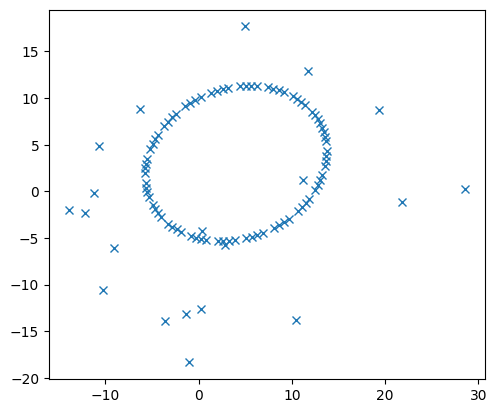

In [ ]:
x_orig, y_orig = generate_points(x0_orig, y0_orig, ap_orig, bp_orig, phi_orig, npts=npts)
# add random noise to every nth point
x = x_orig.copy()
y = y_orig.copy()
n = 5
x[0:npts:n] += np.random.normal(0, ap, npts//n) - ap / 2
y[0:npts:n] += np.random.normal(0, ap, npts//n) - ap / 2
ell_draw(x, y)

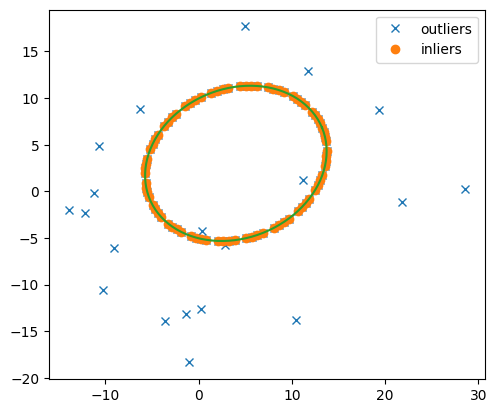

In [ ]:
# RANSAC selection of points
tol = 0.05  # tolerance for point - ellipse distance
xr, yr = ransac_ellipse(x, y, tol)
x0, y0, ap, bp, phi = ellipse(xr, yr)
ell_draw(x, y, xr, yr, x0, y0, ap, bp, phi)